### Check global tropospheric ozone burden time series

In [1]:
import datetime
import warnings
from pathlib import Path

import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

In [2]:
from util_commons import EXPERIMENTS, GASES
from util_mypaths import path_to_raw, path_to_results
from util_plot_func import use_draft_style

In [3]:
warnings.filterwarnings("ignore", module="iris")
register_matplotlib_converters()  # for tstamps
use_draft_style()

In [4]:
# Switches
exp = "FIRE"
trop_def = "chemical"  # diagnostic or chemical
S60N60 = False  # True or False

In [5]:
# Load data
path_to_exp = path_to_raw / EXPERIMENTS[exp]
o3 = iris.load_cube(
    str(path_to_exp / f"{EXPERIMENTS[exp]}_check.pp"), "mass_fraction_of_ozone_in_air"
)
air_mass = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_check.pp"), "m01s34i363")
air_mass.units = "kg"

o3.rename("o3")

In [6]:
# Define troposphere
if trop_def == "diagnostic":
    # Use tropospheric mask fraction [unitless]
    trop_mask = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_trop_mask.nc"))
    trop_tex = "tropospheric mask fraction"
    trop_str = "tropdiag"
elif trop_def == "chemical":
    # One where O3 is less than 125 ppb
    molar_mass_air = iris.coords.AuxCoord(GASES["air"]["molar_mass"], units="g mol-1")
    molar_mass_o3 = iris.coords.AuxCoord(GASES["o3"]["molar_mass"], units="g mol-1")
    coeff_o3 = molar_mass_air.points[0] / molar_mass_o3.points[0] * 1e9
    trop_mask_bool = np.ma.masked_less(o3.data * coeff_o3, 125).mask
    trop_mask = o3.copy(data=trop_mask_bool)
    trop_mask.rename("chemical troposphere")
    trop_tex = "125 ppb ozonopause"
    trop_str = "tropchem"
    trop_mask.units = "1"

# Define 60S-60N region for comparison with TOAR
if S60N60:
    S60N60_constraint = iris.Constraint(latitude=lambda cell: -60 <= cell <= 60)
    o3 = o3.extract(S60N60_constraint)
    air_mass = air_mass.extract(S60N60_constraint)
    trop_mask = trop_mask.extract(S60N60_constraint)
    S60N60_tex = "60\u00B0S-60\u00B0N "
    S60N60_str = "60S60N"
else:
    S60N60_tex = ""
    S60N60_str = ""

In [7]:
# Create datetime coordinate for plotting
cb = o3.copy()
iris.coord_categorisation.add_year(cb, "time", name="year")
iris.coord_categorisation.add_month(cb, "time", name="month")
tstamp0 = datetime.datetime.strptime(
    f"{cb.coord('year').points[0]} " + cb.coord("month").points[0], "%Y %b"
)
tstamp1 = datetime.datetime.strptime(
    f"{cb.coord('year').points[-1]} " + cb.coord("month").points[-1], "%Y %b"
)
tstamps = pd.date_range(tstamp0, tstamp1, freq="MS")

In [8]:
def calc_burden(cube, air_mass, trop_mask):
    """Calculate the global tropospheric burden of a selected species in Tg."""
    burden = (cube * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    burden.convert_units("Tg")
    burden.rename(cube.name())
    return burden

In [9]:
o3_burden = calc_burden(o3, air_mass, trop_mask)

In [10]:
def plt_burden_time_series(cube):
    fig, ax = plt.subplots()
    ax.plot(tstamps, cube.data, color="k")

    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_title(
        f"Tropospheric {GASES[cube.name()]['tex']} burden\n({S60N60_tex}using {trop_tex})",
        loc="right",
    )
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Tg")
    # Format xticklabels
    iris.coord_categorisation.add_year(cube, "time", name="year")
    iris.coord_categorisation.add_month(cube, "time", name="month")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cube.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)

    figname = "_".join(
        [i for i in [EXPERIMENTS[exp], cube.name(), "burden", trop_str, S60N60_str] if i]
    )


#     fig.savefig(path_to_results / EXPERIMENTS[exp] / "metrics" / figname)

/home/maria/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


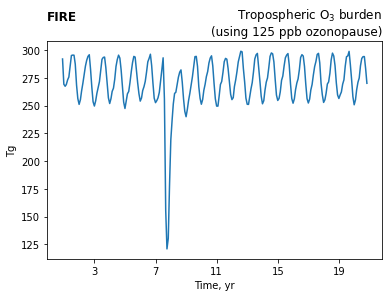

In [11]:
plt_burden_time_series(o3_burden)

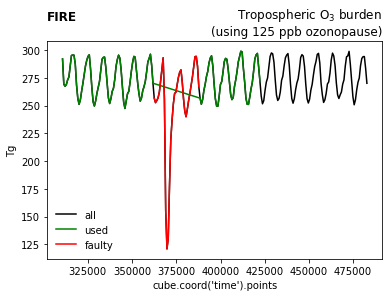

In [12]:
# Highlight faulty data
if exp == "FIRE":
    fig, ax = plt.subplots()
    ax.plot(o3_burden.coord("time").points, o3_burden.data, color="k", label="all")
    ax.plot(
        o3_burden.coord("time").points[[*range(12 * 6)] + [*range(12 * 9, 12 * 13)]],
        o3_burden.data[[*range(12 * 6)] + [*range(12 * 9, 12 * 13)]],
        color="g",
        label="used",
    )
    ax.plot(
        o3_burden.coord("time").points[12 * 6 : 12 * 9],
        o3_burden.data[12 * 6 : 12 * 9],
        color="r",
        label="faulty",
    )
    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_title(
        f"Tropospheric {GASES[o3_burden.name()]['tex']} burden\n({S60N60_tex}using {trop_tex})",
        loc="right",
    )
    ax.set_xlabel("cube.coord('time').points")
    ax.set_ylabel("Tg")
    ax.legend(frameon=False)

In [13]:
# Find timestamps without faulty data
if exp == "FIRE":
    timestamps_without_faulty_data = o3_burden.coord("time").units.num2date(
        o3_burden.coord("time").points[[*range(12 * 6)] + [*range(12 * 9, 12 * 13)]]
    )
    print(timestamps_without_faulty_data)

[cftime.Datetime360Day(2005, 12, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 1, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 2, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 3, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 4, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 5, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 6, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 7, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 8, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 9, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 10, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 11, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2006, 12, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 1, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 2, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 3, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 4, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 5, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 6, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 7, 16, 0, 0, 0, 0)
 cftime.Datetime360Day(2007, 8, 16, 